## Data Preparation

In [18]:
# load data
import tensorflow
from tensorflow import keras
import numpy as np
from scipy.io import loadmat
data = loadmat('data_norm_160.mat')
data = data['data_norm']

In [19]:
# split data randomly (100,40,20)
idx = np.random.permutation(160)
print(idx)
idx_train = idx[0:100]
idx_val = idx[100:140]
idx_test = idx[140:]
print(idx_train,idx_val,idx_test)
data_train = data[idx_train,0]
data_val = data[idx_val,0]
data_test = data[idx_test,0]

[  0 155 127   3 100 148  92  77   1  15 141  87   2 103  12 157  50 128
  61 109  86 159 156 111  83  57  80 142  19  23  60 135 115  24  51 125
 124 101  31 120  74  41 146  29  99 139  33  96  67 108 105  76  18  38
 134  85 133  55  58  59  25 110  97 138  94  66  49  36  16  40  63  79
  64  26 152 143  35  78 102  98  42  65  88  30  82 129 114 113  22 158
  73 107  45  68 153  93  69  84  28  95 154  44  89 121 130   5  91 123
  32  27  39 106  13   7  11  56  62  46 151  90  48 122 118 126 150  17
 117  20  53  75 131 119   4 104  81 112  37 116 140   9 136 144  47   8
  10  52  71   6 132  21  34  43 137 145  72  70 147  54 149  14]
[  0 155 127   3 100 148  92  77   1  15 141  87   2 103  12 157  50 128
  61 109  86 159 156 111  83  57  80 142  19  23  60 135 115  24  51 125
 124 101  31 120  74  41 146  29  99 139  33  96  67 108 105  76  18  38
 134  85 133  55  58  59  25 110  97 138  94  66  49  36  16  40  63  79
  64  26 152 143  35  78 102  98  42  65  88  30  82 129 1

In [20]:
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from numpy import shape
from numpy import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix,0:-1] #label prediction removed
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [21]:
# define input sequence
X_train,y_train,X_val,y_val,X_test,y_test = list(),list(),list(),list(),list(),list()
# choose a number of time steps
n_steps_in, n_steps_out = 30, 3
for i in range(data_train.shape[0]):
    dataset = data_train[i][:,1:] # drop time series
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    X_train.append(X)
    y_train.append(y)
for i in range(data_val.shape[0]):
    dataset = data_val[i][:,1:] # drop time series
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    X_val.append(X)
    y_val.append(y)
for i in range(data_test.shape[0]):
    dataset = data_test[i][:,1:] # drop time series
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    X_test.append(X)
    y_test.append(y)

In [22]:
# push all lists into one 3D array
X_train_all,y_train_all,X_val_all,y_val_all,X_test_all,y_test_all = X_train[0],y_train[0],X_val[0],y_val[0],X_test[0],y_test[0]
for i in range(1,shape(X_train)[0]):
    X_train_all = concatenate((X_train_all,X_train[i]))
    y_train_all = concatenate((y_train_all,y_train[i]))
for i in range(1,shape(X_val)[0]):
    X_val_all = concatenate((X_val_all,X_val[i]))
    y_val_all = concatenate((y_val_all,y_val[i]))
for i in range(1,shape(X_test)[0]):
    X_test_all = concatenate((X_test_all,X_test[i]))
    y_test_all = concatenate((y_test_all,y_test[i]))

In [23]:
# y_train_all.reshape(y_train_all.shape[0],y_train_all.shape[1],1)
# y_val_all.reshape(y_val_all.shape[0],y_val_all.shape[1],1)

In [24]:
# save X_train,y_train,X_val,y_val,X_test,y_test
from numpy import savez_compressed
savez_compressed('X_train_all.npz',X_train_all)
savez_compressed('y_train_all.npz',y_train_all)
savez_compressed('X_val_all.npz',X_val_all)
savez_compressed('y_val_all.npz',y_val_all)
savez_compressed('X_test_all.npz',X_test_all)
savez_compressed('y_test_all.npz',y_test_all)

In [25]:
# from numpy import savez
# savez('E:/Study/Jupyter/Forecasting/Data/X_train_all2.npz','X_train_all')
# savez('E:/Study/Jupyter/Forecasting/Data/y_train_all2.npz','y_train_all')
# savez('E:/Study/Jupyter/Forecasting/Data/X_val_all2.npz','X_val_all')
# savez('E:/Study/Jupyter/Forecasting/Data/y_val_all2.npz','y_val_all')
# savez('E:/Study/Jupyter/Forecasting/Data/X_test_all2.npz','X_test_all')
# savez('E:/Study/Jupyter/Forecasting/Data/y_test_all2.npz','y_test_all')

In [26]:
# # customize keras.model.fit
# class CustomModel(tensorflow.keras.Model):
#     def train_step(self, data):
#         # Unpack the data. Its structure depends on your model and
#         # on what you pass to `fit()`.
#         x, y = data

#         with tf.GradientTape() as tape:
#             y_pred = self(x, training=True)  # Forward pass
#             # Compute the loss value
#             # (the loss function is configured in `compile()`)
#             loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

#         # Compute gradients
#         trainable_vars = self.trainable_variables
#         gradients = tape.gradient(loss, trainable_vars)
#         # Update weights
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))
#         # Update metrics (includes the metric that tracks the loss)
#         self.compiled_metrics.update_state(y, y_pred)
#         # Return a dict mapping metric names to current value
#         return {m.name: m.result() for m in self.metrics}

In [27]:
# the dataset knows the number of features, e.g. 2
n_features = 11
n_epochs = 100
# define model
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(300, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(10)))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# fit and save model
model.fit(X_train_all, y_train_all, epochs=n_epochs,validation_data=(X_val_all, y_val_all),verbose=2)

Epoch 1/10
744/744 - 57s - loss: 0.0133 - mae: 0.0754 - val_loss: 0.0061 - val_mae: 0.0581
Epoch 2/10
744/744 - 55s - loss: 0.0041 - mae: 0.0451 - val_loss: 0.0052 - val_mae: 0.0512
Epoch 3/10
744/744 - 56s - loss: 0.0030 - mae: 0.0380 - val_loss: 0.0042 - val_mae: 0.0439
Epoch 4/10
744/744 - 55s - loss: 0.0025 - mae: 0.0344 - val_loss: 0.0028 - val_mae: 0.0377
Epoch 5/10
744/744 - 55s - loss: 0.0021 - mae: 0.0315 - val_loss: 0.0023 - val_mae: 0.0331
Epoch 6/10
744/744 - 55s - loss: 0.0019 - mae: 0.0295 - val_loss: 0.0021 - val_mae: 0.0323
Epoch 7/10
744/744 - 55s - loss: 0.0016 - mae: 0.0275 - val_loss: 0.0020 - val_mae: 0.0316
Epoch 8/10
744/744 - 54s - loss: 0.0015 - mae: 0.0261 - val_loss: 0.0014 - val_mae: 0.0246
Epoch 9/10
744/744 - 53s - loss: 0.0014 - mae: 0.0249 - val_loss: 0.0015 - val_mae: 0.0277
Epoch 10/10
744/744 - 54s - loss: 0.0013 - mae: 0.0240 - val_loss: 0.0015 - val_mae: 0.0289


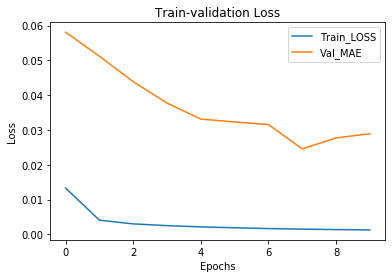

In [28]:
train_loss = model.history.history['loss']
val_mae = model.history.history['val_mae']
savez_compressed('train_loss.npz',train_loss)
savez_compressed('val_mae.npz',val_mae)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(n_epochs),train_loss,label="Train_LOSS")
plt.plot(range(n_epochs),val_mae,label="Val_MAE")
plt.legend()
plt.title("Train-validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [29]:
plt.savefig("train-val_loss.png")

<Figure size 432x288 with 0 Axes>

In [30]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [31]:
model.save('LSTM_All.h5')

In [32]:
# demonstrate prediction--test
x_input = X_test_all
print(x_input.shape)
reconstructed_model = keras.models.load_model('LSTM_All.h5')
yhat_test = reconstructed_model.predict(x_input, verbose=0)
savez_compressed('y_test_hat.npz',yhat_test)
print(yhat_test.shape)

# demonstrate prediction--val
x_input = X_val_all
print(x_input.shape)
reconstructed_model = keras.models.load_model('LSTM_All.h5')
yhat_val = reconstructed_model.predict(x_input, verbose=0)
savez_compressed('y_val_hat.npz',yhat_val)
print(yhat_val.shape)

# demonstrate prediction--train
x_input = X_train_all
print(x_input.shape)
reconstructed_model = keras.models.load_model('LSTM_All.h5')
yhat_train = reconstructed_model.predict(x_input, verbose=0)
savez_compressed('y_train_hat.npz',yhat_train)
print(yhat_train.shape)

(4567, 30, 11)
(4567, 3, 10)
(9095, 30, 11)
(9095, 3, 10)
(23778, 30, 11)
(23778, 3, 10)
